## Introduction to the SAMPLED BASED DIAGONALIZATION

In [82]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

In [147]:
nparticles_a=6
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{26}$Mg'


In [148]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-114.07487317]
total_m= [3.90854883e-17]
dimension= 51630


#### Select the samples

In [149]:
prob=np.conjugate(psi0[:,0])*psi0[:,0]
prob_nozero=prob[prob>10**-25].copy()/np.sum(prob[prob>10**-25].copy())
nozero_index=np.arange(prob.shape[0])[prob>10**-25]
print(prob_nozero.shape)

(51562,)


In [150]:

n_instances=20
bins=int(0.2*NSMHamiltonian.hamiltonian.shape[0])
print(bins)
selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances,replace=False,p=prob)

effective_hamiltonian=lil_matrix((n_instances,n_instances))

for a,idx_a in enumerate(selection):
    for b,idx_b in enumerate(selection):
        effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]


effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')

print(effective_egs)


10326
[-102.58858306]


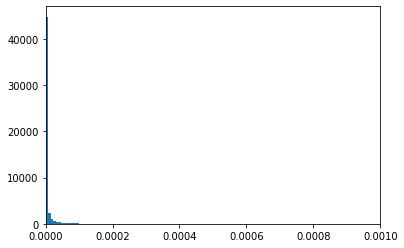

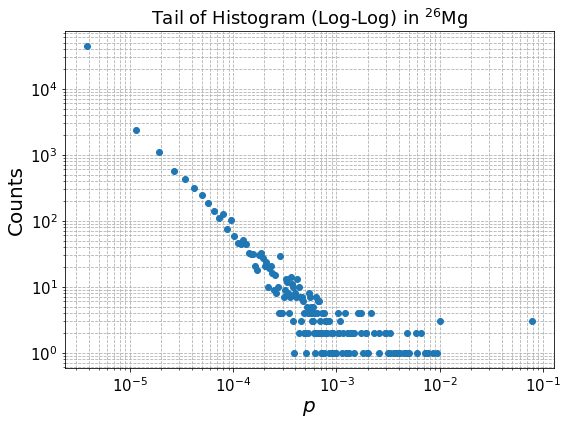

In [151]:

plt.hist(prob_nozero,bins=bins)
plt.xlim([0,10**-3])
plt.show()

# Compute histogram (don't plot yet)
counts, bin_edges = np.histogram(prob_nozero, bins=bins,density=False)

# Bin centers (x-axis)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Filter out zero counts to avoid log(0)
nonzero = counts > 0
counts = counts[nonzero]


bin_centers = bin_centers[nonzero]
bin_widths = np.diff(bin_edges)


pdf = counts #/ (np.sum(counts))

# Plot in log-log scale
plt.figure(figsize=(8,6))
plt.loglog(bin_centers, pdf, marker='o', linestyle='none')
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize=15)
plt.title(r"Tail of Histogram (Log-Log) in "+title, fontsize=18)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [152]:
e_values=[]
errors=[]
nbatches=100
for i in range(pdf.shape[0]):
    n_instances=np.sum(counts[-i-1:])
    print(n_instances)
    e_ave=0.
    for r in range(nbatches):
        
        selection=np.random.choice(nozero_index,size=n_instances,replace=False,p=prob_nozero)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        #print(effective_hamiltonian.shape)
        if effective_hamiltonian.shape[0]==1:
            effective_egs=NSMHamiltonian.hamiltonian.tocsr()[selection,selection][0,0]

        else:
            effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
            effective_egs=effective_egs[0]



        e_ave+=effective_egs

    e_ave=e_ave/nbatches
    print(e_ave)
    error=np.abs(e_ave-egs[0])/np.abs(egs[0])
    errors.append(error)
    e_values.append(e_ave)


3
-96.76133640989266
6
-100.7086724885147
7


-101.06643915463621
8
-101.39160972460125
9
-101.60374911397606
10
-101.57738124589515
11
-101.90216326472343
12
-102.19910687905583
13
-102.12826265811087
14
-102.43750355336313
15
-102.60137005484789
17
-102.72420680209933
18
-102.78522270124006
20
-102.91342056026294
21
-102.90237694563298
22
-103.10830858287746
24
-103.169265986065
25
-103.2008767696366
26
-103.22318089556413
27
-103.22892028862817
28
-103.33912404166144
29
-103.29970362346725
30
-103.41900824086373
31
-103.3663000958498
32
-103.46350344597
33
-103.51845940262896
35
-103.54461060255646
36
-103.5950305739733
38
-103.59887668261412
40
-103.71155892140985
42
-103.75528481244847
43
-103.75354905351655
45
-103.85178164669003
49
-103.89919022881051
50
-103.91640394748703
51
-103.93326818344212
53
-103.97015599085704
55
-104.01691937402774
56
-104.05909595681297
60
-104.16067979932157
62
-104.21363926037688
66
-104.2846848802595
67
-104.26283035972982
69
-104.33788657240211
71
-104.40692356935713
73
-104.46171181425552
75

In [153]:


errors.reverse()
e_values.reverse()

errors=np.asarray(errors)
e_values=np.asarray(e_values)


[7.47448811e-16 1.37318812e-02 1.92918173e-02 2.31435293e-02
 2.57677438e-02 2.82314455e-02 3.03129965e-02 3.21950963e-02
 3.39200212e-02 3.52188236e-02 3.64959039e-02 3.81173004e-02
 3.90802195e-02 4.07040095e-02 4.14171631e-02 4.22582201e-02
 4.29233943e-02 4.39462970e-02 4.48632682e-02 4.55986417e-02
 4.61606857e-02 4.68911109e-02 4.74738305e-02 4.78098974e-02
 4.86395241e-02 4.94332337e-02 5.02871442e-02 5.09499716e-02
 5.17529124e-02 5.18578213e-02 5.26579670e-02 5.31945541e-02
 5.38562299e-02 5.41090633e-02 5.48343393e-02 5.51288711e-02
 5.54762653e-02 5.56081839e-02 5.69273826e-02 5.69839900e-02
 5.70380442e-02 5.75139385e-02 5.78642372e-02 5.83154609e-02
 5.88700277e-02 5.93745857e-02 5.95656924e-02 6.01131415e-02
 6.07410067e-02 6.13219721e-02 6.14613015e-02 6.19080798e-02
 6.20482686e-02 6.27184637e-02 6.34392719e-02 6.37991096e-02
 6.45964005e-02 6.44294469e-02 6.49563606e-02 6.52292339e-02
 6.58937655e-02 6.59788886e-02 6.66498968e-02 6.65885896e-02
 6.68185162e-02 6.684448

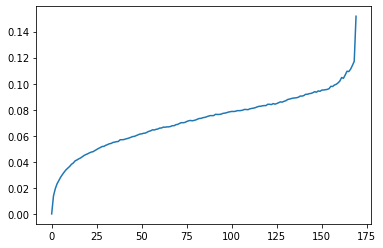

In [154]:

print(errors)
plt.plot(errors+10**-5)

plt.show()

[2.97638521e-06 8.92915277e-06 1.48819203e-05 2.08346879e-05
 2.67874555e-05 3.27402230e-05 3.86929906e-05 4.46457582e-05
 5.05985257e-05 5.65512933e-05 6.25040609e-05 6.84568284e-05
 7.44095960e-05 8.03623636e-05 8.63151311e-05 9.22678987e-05
 9.82206662e-05 1.04173434e-04 1.10126201e-04 1.16078969e-04
 1.22031737e-04 1.27984504e-04 1.33937272e-04 1.39890039e-04
 1.45842807e-04 1.51795574e-04 1.57748342e-04 1.63701109e-04
 1.69653877e-04 1.75606645e-04 1.81559412e-04 1.87512180e-04
 1.93464947e-04 1.99417715e-04 2.05370482e-04 2.11323250e-04
 2.17276018e-04 2.23228785e-04 2.29181553e-04 2.35134320e-04
 2.41087088e-04 2.47039855e-04 2.52992623e-04 2.58945391e-04
 2.64898158e-04 2.70850926e-04 2.76803693e-04 2.82756461e-04
 2.88709228e-04 2.94661996e-04 3.00614763e-04 3.06567531e-04
 3.12520299e-04 3.18473066e-04 3.24425834e-04 3.30378601e-04
 3.36331369e-04 3.42284136e-04 3.48236904e-04 3.54189672e-04
 3.60142439e-04 3.66095207e-04 3.72047974e-04 3.78000742e-04
 3.89906277e-04 3.958590

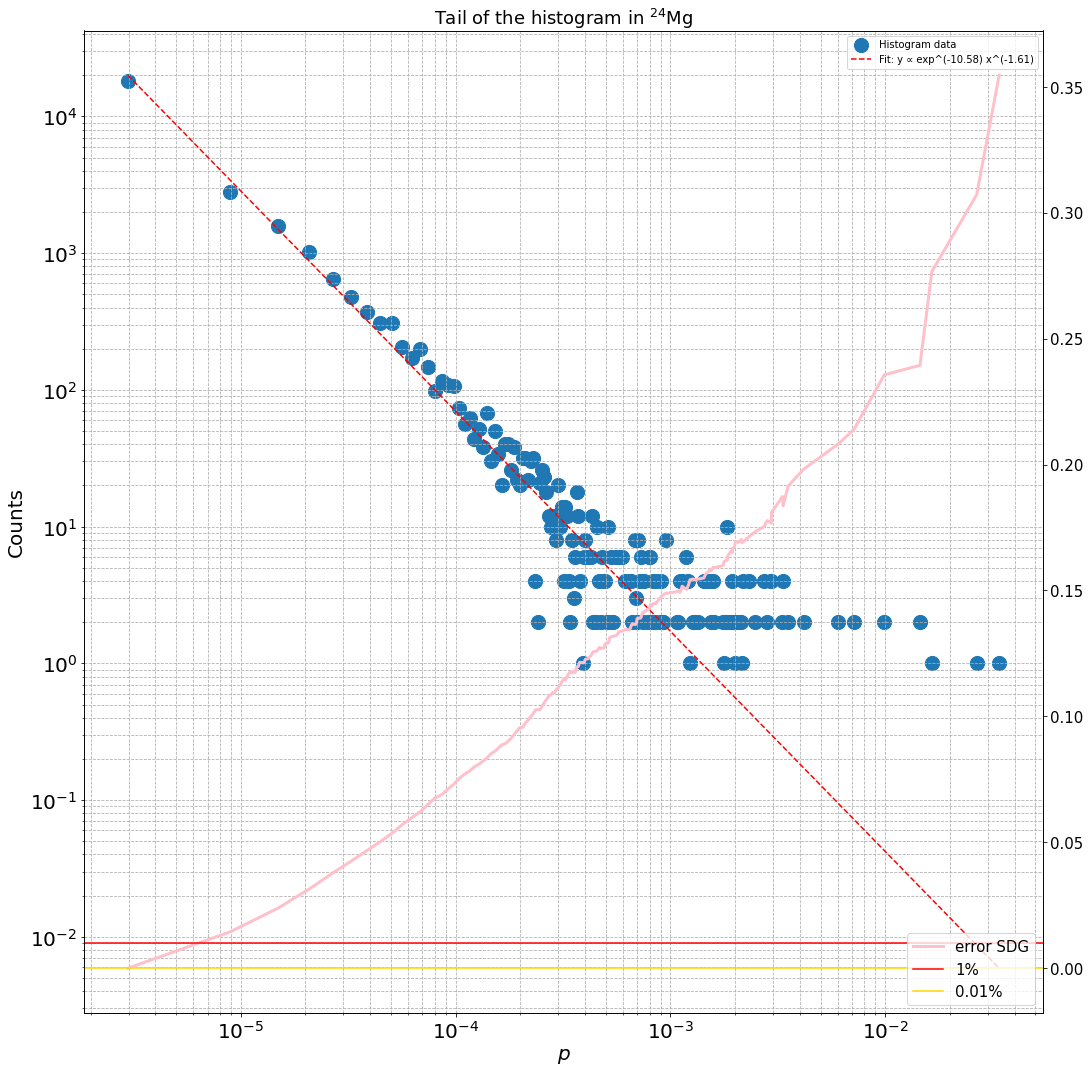

In [146]:
from scipy import stats
mask = counts > 0
x = bin_centers[mask]
y = counts[mask]
print(x,y)
# Take logs
logx = np.log(x[x<10**-3])
logy = np.log(y[x<10**-3])
print(logx,logy)
# Fit linear regression in log-log space
slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)

# Extract power-law parameters
b = -slope
a = np.exp(intercept)
print(intercept)
print(f"Fitted power law: y ≈ {a:.6f} * x^(-{b:.3f})")
print(f"R² = {r_value**2:.4f}")

# Plot
fig,ax=plt.subplots(figsize=(15,15))

ax_twin=ax.twinx()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r"Tail of the histogram in "+title, fontsize=18)
ax.scatter(x, y,  label='Histogram data',s=200)
ax.loglog(x, a * x**(-b), 'r--', label=f'Fit: y ∝ exp^({np.log(a):.2f}) x^(-{b:.2f})')
ax.set_xlabel(r'$p$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.tick_params(labelsize=20)
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
ax_twin.plot(x,errors,color='pink',linewidth=3,linestyle='-',label='error SDG')
ax_twin.set_xlabel('relative error(SDG)',fontsize=20)

ax_twin.tick_params(labelsize=15)
ax_twin.axhline(y=0.01,label='1%',color='red')
ax_twin.axhline(y=0.0001,label='0.01%',color='gold')

ax_twin.legend(fontsize=15,loc='lower right')
plt.show()

#### Build-up an algorithm to save the number of instances with a fixed accuracy

Hyperparameters

In [ ]:
nparts=[(2,0),(4,0),(6,0),(8,0),(2,2),(4,2),(6,2),(8,2),(4,4),(6,4),(8,4),(6,6),(8,6),(10,6),(10,8)]
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne',r'$^{24}$Mg',r'$^{26}$Mg',r'$^{28}$Mg',r'$^{28}$Si',r'$^{30}$Si',r'$^{32}$Si',r'$^{32}$Ar']

history={}
errors=[]
n_instances_max=[]

for r,title in enumerate(titles):
    print('title=',title)
    nparticles_a=nparts[r][0]
    nparticles_b=nparts[r][1]
    
    history[nparts[r]]=[]
    
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

    print(egs)

    print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
    #print('j_value=',J2Class.j_value(psi0))
    print('dimension=',NSMHamiltonian.hamiltonian.shape[0])
    
    prob=np.conjugate(psi0[:,0])*psi0[:,0]
    
    n_instances=np.arange(2,prob.shape[0])
    
    error=1000
    i=0
    while(error> 10**-3):
        selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances[i],replace=False,p=prob)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        
        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        error=np.abs(effective_egs[0]-egs[0])/np.abs(egs[0])
        history[nparts[r]].append(error)
        
        i+=1
    
    n_instances_max.append(i)
    errors.append(error)
    print('\n')
    print(n_instances[i])
    print('error=',np.abs(effective_egs[0]-egs[0])/np.abs(egs[0]),'\n')     
    
    

#### Analysis of the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data=np.load('data/samplebaseddiagonalization_data/run_1%.npz')

errors=data['errors']
titles=data['titles']
history=data['history']
n_instances=data['n_instances']
dimensions=data['dimensions']

print(titles)
# 0 5 9 12
selection=[0,5,9,12]
print(titles[selection])

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell',fontsize=30)
plt.ylabel('n instances',fontsize=30)
plt.bar(np.arange(n_instances.shape[0]),dimensions)
plt.bar(np.arange(n_instances.shape[0]),n_instances)
#plt.semilogy()
plt.xticks(np.arange(n_instances.shape[0]),titles[:n_instances.shape[0]])
#plt.text(x=1,y=80000,s=r'$H=\sum_a e_a c^{+}_a c_a +\frac{1}{4}\sum_{abcd} v_{abdc} c^{+}_a c^{+}_b c_c c_d$',fontsize=30)
plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell (1% accuracy energy)',fontsize=30)
plt.ylabel(r'$N_s$',fontsize=30)
plt.xlabel(r'$\dim$',fontsize=30)

plt.scatter(dimensions,dimensions)
plt.plot(dimensions,dimensions)
plt.scatter(dimensions,n_instances)
plt.loglog()

plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.scatter(n_instances,dimensions)
plt.loglog()
plt.show()

from scipy import stats

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming these are your data
# dimensions = ...
# n_instances = ...

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")

# Plot original data and the fitted curve
plt.figure(figsize=(8,6))
plt.scatter(dimensions, n_instances, label='Data', color='blue')

# Create smooth line for fitted curve
x_fit = np.linspace(min(dimensions), max(dimensions), 200)
y_fit = a * x_fit**b
plt.plot(x_fit, y_fit, label=f'Fit: y ≈ {a:.2f} * x^{b:.2f}', color='red', linestyle='--')

# Log scales
plt.xscale('log')
plt.yscale('log')

# Labels
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()
